# Summary

A common task in finance is forecasting values. There are several methods for creating forecasts such as ARIMA, Bayesian Structural Time Series, and simulation. Monte Carlo is a simulation technique based on generating random walks over a period of time. 

# Tutorial Overview
In this module, we will:
1. Import crude oil  prices
2. Simulate future price movements using a Monte Carlo simulation
3. Plot the simulated future paths


In [4]:
# getting historical data for RDS-A. This code calls the API and transforms the result into a DataFrame.
import numpy as np
np.random.seed(4373)
import pandas as pd
from pandas.io.json import json_normalize

from scipy.stats import norm
import datetime 

import matplotlib.pyplot as plt
%matplotlib inline

# Optional step to get fresh data

There is a snapshot of the data already saved in the data file so this step is not required. If you want to pull new data you will need a username and key from the financial modeling prep website.

`ticker = "AOIL" #Aberdeen Oil - Bloomberg index for WTI
base = 'https://financialmodelingprep.com/api/v3/'
key = '<YOUR KEY HERE>'
target = "{}historical-price-full/{}?apikey={}".format(base, ticker, key)
df = pd.read_json(target)
df = json_normalize(df['historical'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.to_csv('AOIL data.csv')`

In [5]:
df = pd.read_csv('data/AOIL data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ticker = "AOIL"

In [6]:
df.head()

,adjClose,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,,
2020-02-27,21.78,0.0,0.0,0.0,21.78,21.78,"February 27, 20",21.78,21.78,0.0,0.0,0.0
2020-02-26,21.78,0.0,0.0,0.0,21.78,21.78,"February 26, 20",21.78,21.78,0.0,0.0,0.0
2020-02-25,21.78,0.0,0.0,0.0,21.78,21.78,"February 25, 20",21.78,21.78,0.0,0.0,0.0
2020-02-24,21.78,0.0,0.0,0.0,21.78,21.78,"February 24, 20",21.78,21.78,0.0,0.0,0.0
2020-02-21,21.78,0.0,0.0,0.0,21.78,21.78,"February 21, 20",21.78,21.78,0.0,0.0,0.0


<AxesSubplot:title={'center':'Price of AOIL from 2017-03-31 00:00:00 to 2020-02-27 00:00:00'}, xlabel='date'>

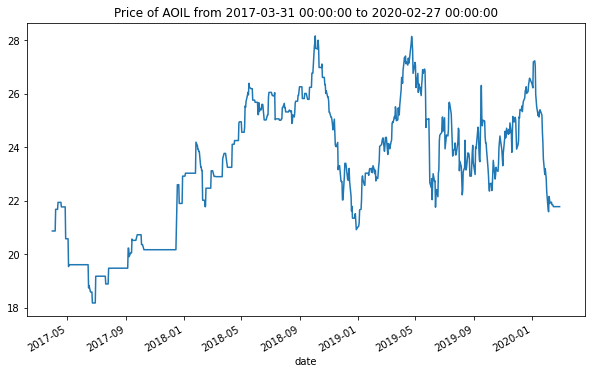

In [7]:
#Plot of asset historical closing price
df['adjClose'].plot(figsize=(10, 6), title = "Price of {} from {} to {}".format(ticker, df.index.min(), df.index.max()))

# Geometric Brownian Motion

We assume the log of the returns (percent changes) are normally distributed. We also assume the market is efficient. 

The formula for the change in price between periods is the price of the stock in $t_0$ multiplied by the expected drift (average change in price) plus an exogenous shock. 
$$\Delta S = S * (\mu \Delta t + \sigma \epsilon * \sqrt{\Delta t}) $$
Where:

$S$ = stock price 

$\Delta S$ = change in stock price 

$\mu$ = expected return 

$\sigma$ = standard deviation of the returns 

$\epsilon$ = random variable 

$\delta t$ = elapsed time 

<AxesSubplot:title={'center':'1000 Simulated Future Paths'}>

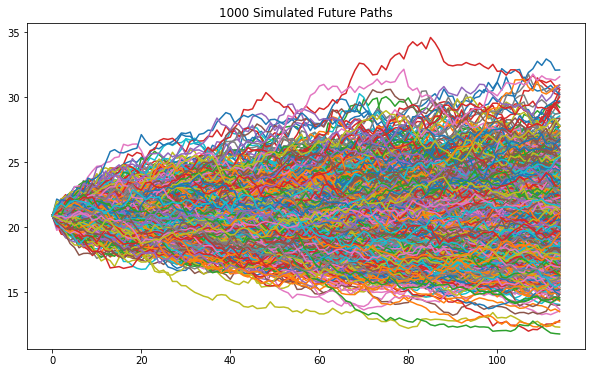

In [8]:
pred_end_date = datetime.datetime(2020, 6, 20)
forecast_dates = [d if d.isoweekday() in range(1, 6) else np.nan for d in pd.date_range(df.index.max(), pred_end_date)] 
intervals = len(forecast_dates)
iterations = 1000
#Preparing log returns from data
log_returns = np.log(1 + df['adjClose'].pct_change())

#Setting up drift and random component in relation to asset data
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(intervals, iterations)))

#Takes last data point as startpoint point for simulation
S0 = df['adjClose'].iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
#Applies Monte Carlo simulation in asset
for t in range(1, intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

forecast_df = pd.DataFrame(price_list)
    

forecast_df.plot(figsize=(10,6), legend=False, title = "{} Simulated Future Paths".format(iterations))


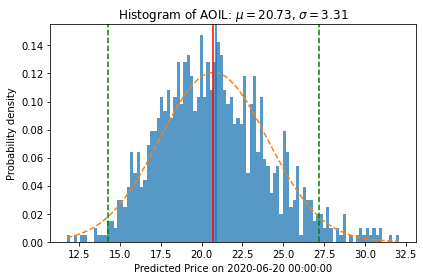

In [11]:
# Plotting with a histogram

x = forecast_df.values[-1]
sigma = np.std(x)
mu = np.mean(x)

num_bins = 100

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1, alpha=.75)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.axvline(np.mean(x), color='r')
ax.axvline(mu+sigma*1.96, color='g', ls='--')
ax.axvline(mu-sigma*1.96, color='g', ls='--')
ax.axvline(S0)
ax.set_xlabel('Predicted Price on {}'.format(pred_end_date))
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of {ticker}: $\mu={mu:.02f}$, $\sigma={sigma:.02f}$'.format(ticker = ticker, mu=mu, sigma=sigma))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()